<a href="https://colab.research.google.com/github/apallath/cats_vs_dogs_models/blob/main/cats_vs_dogs_grad_cam.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Mount Google Drive
import os, shutil
from google.colab import drive
from google.colab import files
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm

import tensorflow as tf
import tensorflow.keras as keras

from tensorflow.keras import models
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.resnet import preprocess_input

In [3]:
model = load_model('/content/drive/MyDrive/colab_models/cats_vs_dogs_resnet50_fine_tuned.h5')
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Functional)        (None, 5, 5, 2048)        23587712  
_________________________________________________________________
global_average_pooling2d (Gl (None, 2048)              0         
_________________________________________________________________
flatten (Flatten)            (None, 2048)              0         
_________________________________________________________________
dropout (Dropout)            (None, 2048)              0         
_________________________________________________________________
dense (Dense)                (None, 256)               524544    
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 257       
Total params: 24,112,513
Trainable params: 24,059,393
Non-trainable params: 53,120
_______________________________________

True:  Dog | Predicted:  Dog Score:  [[1.]]


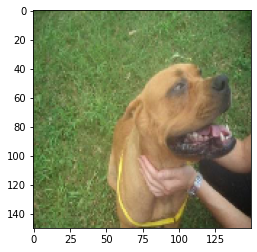

In [4]:
# Dog activates to 1 => load dog images and see what causes the activation to go to 1
test_dogs = '/content/drive/MyDrive/colab_data/cats_vs_dogs_small/test/dogs'

classes = ["Cat", "Dog"]

fnames = [os.path.join(test_dogs, fname) for fname in os.listdir(test_dogs)]
img_path = fnames[np.random.randint(0, 500)]
img = image.load_img(img_path, target_size=(150, 150))
x = image.img_to_array(img)
plt.imshow(x / 255)

predicted = model.predict(preprocess_input(x.reshape(1, 150, 150, 3)))

print("True: ", classes[1] , "| Predicted: ", classes[int(predicted > 0.5)], "Score: ", predicted)

# Grad-CAM algorithm


In [5]:
# Return last conv layer activations and final activation
grad_extractor = models.Model([model.input], [model.output, model.get_layer("resnet50").get_output_at(0)])

In [6]:
with tf.GradientTape() as tape:
    # Get output and last conv activation
    pred, last_conv_output = grad_extractor([x.reshape(1, 150, 150, 3)])

    # Get gradients w.r.t last conv layer output
    grads = tape.gradient(pred, last_conv_output)
    print(grads.shape)

    # Pool gradients: get mean intensity of gradient for each filter
    # Mean intensity is a weight that represents how important that filter is
    # in determining whether the output is of class 'dog'
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
    print(pooled_grads.shape)

    # Multiply each filter features by filter weight
    # and sum over weighted filters (i.e. perform weighted sum) to get heatmap
    heatmap = last_conv_output[0] @ pooled_grads[..., np.newaxis] 
    print(heatmap.shape)

    heatmap = tf.squeeze(heatmap)
    print(heatmap.shape)

    # Normalize heatmap
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)

    heatmap = heatmap.numpy()

(1, 5, 5, 2048)
(2048,)
(5, 5, 1)
(5, 5)


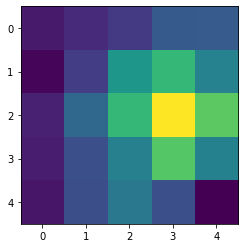

In [7]:
plt.imshow(heatmap)

(5, 5)
(256, 4)
(256, 3)
(5, 5, 3)


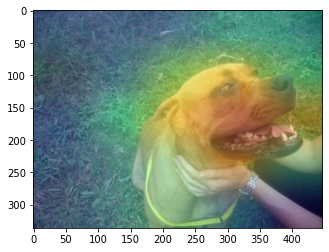

In [8]:
# Rescale, recolor, and reshape heatmap
colormap = cm.get_cmap("jet")
heatmap = np.uint8(255 * heatmap)
print(heatmap.shape)

colormap_colors = colormap(np.arange(256))
print(colormap_colors.shape)

colormap_colors = colormap_colors[..., :3]
print(colormap_colors.shape)

colormap_heatmap = colormap_colors[heatmap]
print(colormap_heatmap.shape)

# Superimposed visualization
img = image.load_img(img_path)
img = keras.preprocessing.image.img_to_array(img)

colormap_heatmap = keras.preprocessing.image.array_to_img(colormap_heatmap)
colormap_heatmap = colormap_heatmap.resize((img.shape[1], img.shape[0]))
colormap_heatmap = keras.preprocessing.image.img_to_array(colormap_heatmap)

superimposed_img = 0.4 * colormap_heatmap + img
superimposed_img = keras.preprocessing.image.array_to_img(superimposed_img)

plt.imshow(superimposed_img)